Image CRS: EPSG:32629
Image Bounds: xmin: 550000.0, ymin: 5985000.0, xmax: 735000.0, ymax: 6135000.0
Reprojected Bounds: xmin: -8.237012511319886, ymin: 54.01086601694723, xmax: -5.297260972824938, ymax: 55.30518642050943


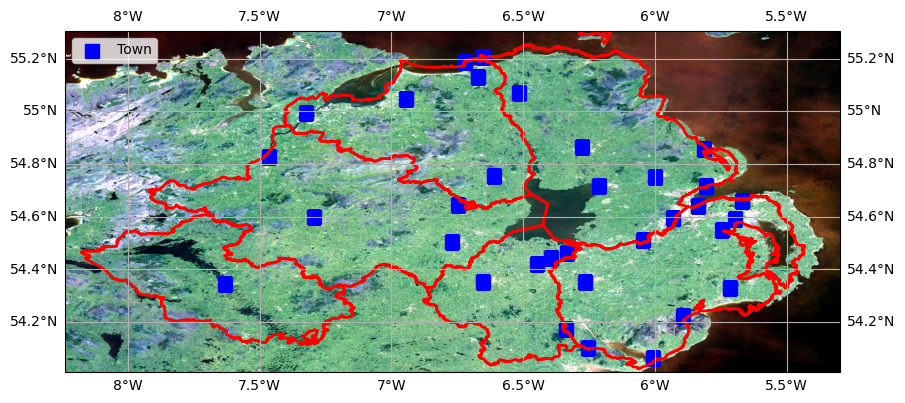

In [2]:
import numpy as np
import rasterio as rio
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from pyproj import CRS, Transformer
from shapely.geometry import Polygon
from cartopy.feature import ShapelyFeature

# Function to stretch the image values based on percentiles
def percentile_stretch(img, pmin=0., pmax=100.):
    '''
    Stretch image values to the percentile range defined by pmin and pmax.
    '''
    if not 0 <= pmin < pmax <= 100:
        raise ValueError('0 <= pmin < pmax <= 100')
    if not img.ndim == 2:
        raise ValueError('Image can only have two dimensions (row, column)')

    minval = np.percentile(img, pmin)
    maxval = np.percentile(img, pmax)

    stretched = (img - minval) / (maxval - minval)
    stretched[img < minval] = 0
    stretched[img > maxval] = 1

    return stretched

# Function to display the image with optional stretch parameters for each band
def img_display(img, ax, bands, stretch_args=None, **imshow_args):
    '''
    Display the image with optional stretch parameters for each band.
    '''
    dispimg = img.copy().astype(np.float32)

    for b in range(img.shape[0]):
        if stretch_args is None:
            dispimg[b] = percentile_stretch(img[b])
        else:
            dispimg[b] = percentile_stretch(img[b], **stretch_args)

    dispimg = dispimg.transpose([1, 2, 0])
    handle = ax.imshow(dispimg[:, :, bands], **imshow_args)

    return handle, ax

# Open the satellite image and check its CRS
with rio.open('data_files/NI_Mosaic.tif') as dataset:
    img = dataset.read()  # Read image
    xmin, ymin, xmax, ymax = dataset.bounds  # Get image bounds
    crs = dataset.crs  # Get the CRS of the image
    print(f"Image CRS: {crs}")
    print(f"Image Bounds: xmin: {xmin}, ymin: {ymin}, xmax: {xmax}, ymax: {ymax}")

# Define the target CRS (geographic coordinates, PlateCarree)
target_crs = CRS.from_epsg(4326)  # WGS 84 (latitude/longitude)

# If the current CRS is different, reproject the bounding box coordinates
if crs != target_crs:
    transformer = Transformer.from_crs(crs, target_crs, always_xy=True)
    xmin, ymin = transformer.transform(xmin, ymin)
    xmax, ymax = transformer.transform(xmax, ymax)

# Check the transformed coordinates
print(f"Reprojected Bounds: xmin: {xmin}, ymin: {ymin}, xmax: {xmax}, ymax: {ymax}")

# Load the shapefiles for county boundaries, towns, and the NI outline
counties = gpd.read_file('data_files/counties.shp')
towns = gpd.read_file('data_files/towns.shp')
boundaries = gpd.read_file('data_files/NI_outline.shp')

# Create the figure and axis objects with Cartopy projection
fig, ax = plt.subplots(figsize=(10, 10), dpi=100, subplot_kw={'projection': ccrs.PlateCarree()})

# Set the extent of the map using the reprojected bounding box values
ax.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())

# Add the NI outline (shapefile)
boundaries_feature = ShapelyFeature(boundaries.geometry, ccrs.PlateCarree(), edgecolor='black', facecolor='none', linewidth=2)
ax.add_feature(boundaries_feature)

# Add county boundaries
counties_feature = ShapelyFeature(counties.geometry, ccrs.PlateCarree(), edgecolor='red', facecolor='none', linewidth=2)
ax.add_feature(counties_feature)

# Add town points (blue squares)
ax.scatter(towns.geometry.x, towns.geometry.y, color='blue', s=100, label='Town', marker='s')

# Add gridlines for reference
ax.gridlines(draw_labels=True)

# Add a legend
ax.legend(loc='upper left')

# Get the stretched image array only
stretched = np.stack([
    percentile_stretch(img[i], pmin=2, pmax=98) for i in (0, 1, 2)
], axis=-1)

extent = (xmin, xmax, ymin, ymax)

# Display the satellite image on the map
ax.imshow(stretched, extent=extent, transform=ccrs.PlateCarree())


# Ensure the image is being rendered properly
if img is not None:
    # Display the satellite image
    img_display(img, ax, bands=[0, 1, 2], stretch_args={'pmin': 2, 'pmax': 98})

# Save the figure to a file before showing it (to ensure the content is saved)
plt.savefig('output_map.png', dpi=300, transparent=True)

# Show the map
plt.show()